In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize
import ddm
import ddm.plot
import os 

# Loss function definitions

In [2]:
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    exp_data = pd.read_csv('../data/measures.csv', 
                            usecols=['subj_id', 'RT', 'is_turn_decision', 'tta_condition', 'd_condition'])
           
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        # If the model produces very fast RTs, interpolated cdf(0) can be >0.1, then we cannot find root like usual
        # In this case, the corresponding rt quantile is half of the time step of cdf
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              if (cdf_interp(0)<quantile) else self.dt/2
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        solultions = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(solultions[c].prob_correct() - comb_sample.prob_correct())**2            
            # Sometimes model p_correct is very close to 0, then RT distribution is weird, in this case ignore RT error 
            if ((solultions[c].prob_correct()>0.001) & (comb_sample.prob_correct()>0)):
#                 self.condition_data = self.exp_data[(self.exp_data.d_condition==comb['d_condition']) 
#                                                     & (self.exp_data.tta_condition==comb['tta_condition'])]
                model_rt_q = self.get_rt_quantiles(solultions[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS
    
    
class LossWLSVincent(LossWLS):
    name = '''Weighted least squares as described in Ratcliff & Tuerlinckx 2002, 
                fitting to the quantile function vincent-averaged per subject (Ratcliff 1979)'''
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        if exp:            
            subject_quantiles = self.condition_data.groupby('subj_id').apply(lambda d: np.quantile(a=d.RT, q=self.rt_quantiles))
            return subject_quantiles.mean()
        else:
            return super().get_rt_quantiles(x, t_domain, exp=False)

# Helper functions

In [3]:
def get_model_measures(model, condition):
    sol = model.solve(condition)
    return condition['tta_condition'], condition['d_condition'], sol.prob_correct(), sol.mean_decision_time()
        
def save_fitting_results(exp_data, fit_model, directory):
    print(fit_model.name)
    print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
    print('Number of parameters: %i' % (len(fit_model.get_model_parameters())-1))
    print('Parameter values: ', fit_model.get_model_parameters())
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    conditions = [{'tta_condition': tta, 'd_condition': d} 
                  for tta in exp_data.tta_condition.unique() 
                  for d in exp_data.d_condition.unique()]
    model_measures = [get_model_measures(fit_model, condition) for condition in conditions]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'd_condition', 'is_turn_decision', 'RT'])
    model_measures['loss'] = fit_model.get_fit_result().value()    
    model_measures.to_csv(os.path.join(directory, 'measures.csv'), index=False)
    
    rt_dfs = []
    for condition in conditions:
        sol = fit_model.solve(condition)
        rt_df = pd.DataFrame({'tta_condition': condition['tta_condition'],
                              'd_condition':  condition['d_condition'],
                              't': fit_model.t_domain(),
                              'rt_corr_pdf': sol.pdf_corr()/sol.prob_correct()})
        rt_dfs.append(rt_df)
    rt_dfs = pd.concat(rt_dfs)
    rt_dfs.to_csv(os.path.join(directory, 'rt_pdf.csv'), index=False)

# Model definitions

Duration of model simulations is set to 2.5 (upper boundary on experimentally observed response times)

In [4]:
T_dur = 2.5

### Model 1. DDM with TTA-dependent drift 

In [15]:
class DriftTtaDistance(ddm.models.Drift):
    name = 'Drift depends on TTA and distance'
    required_parameters = ['alpha', 'tta_crit', 'beta', 'd_crit']
    required_conditions = ['tta_condition', 'd_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        v = conditions['d_condition']/conditions['tta_condition']
        return (self.alpha*(conditions['tta_condition'] - t - self.tta_crit + 
                            self.beta*(conditions['d_condition'] - v*t - self.d_crit)))

In [16]:
model_tta_distance_dependent_drift = ddm.Model(name='1 TTA- and d-dependent drift',
                                      drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      T_dur=T_dur)

In [17]:
model_tta_distance_dependent_drift.get_model_parameters()

[Fittable(minval=0.1, maxval=3),
 Fittable(minval=3, maxval=6),
 Fittable(minval=0, maxval=1),
 Fittable(minval=90, maxval=150),
 1,
 Fittable(minval=0.1, maxval=3.0)]

### Model 2. Model 1 + nondecision time

In [33]:
model_nondecision_time_fixed = ddm.Model(name='2 TTA- and d-dependent drift and fixed nondecision time',
                                      drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      overlay=ddm.OverlayNonDecision(nondectime=ddm.Fittable(minval=0, maxval=0.5)),
                                      T_dur=T_dur)

### Model 3. Model 2 + nondecision time variability

In [34]:
model_nondecision_time_variable = ddm.Model(name='3 TTA- and d-dependent drift and uniformly distributed nondecision time',
                                     drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                     noise=ddm.NoiseConstant(noise=1),
                                     bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                     overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                           halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                     T_dur=T_dur)

### Model 4. Model 3 + collapsing bounds

In [35]:
model_collapsing_bounds = ddm.Model(name='4 TTA- and d-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds',
                                    drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                    noise=ddm.NoiseConstant(noise=1),
                                    bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=0.5, maxval=5), 
                                                                         tau=ddm.Fittable(minval=0.5, maxval=5)),
                                    overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                          halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                    T_dur=T_dur)

### Model 5. Model 3 + TTA-dependent bounds

In [59]:
def plot_b_vs_tau(b_0, k, tta_crit, tta_0, ax):
    tau = np.linspace(3, 7)   
    b = lambda tau: b_0/(1+np.exp(-k*(tau-tta_crit)))

    ax.plot(tau, b(tau))    
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('boundary')
    ax.set_ylim((0, max(b(tau))))
    ax.axvline(tta_crit, color='grey', ls='--')
    ax.set_title(r'$b = b_0/(1+e^{-k(\tau-\tau_{crit})})$')
    ax.text(x=tta_crit, y=min(b(tau)), s=r'$\tau_{crit}=%.2f$' % (tta_crit), fontsize=14);

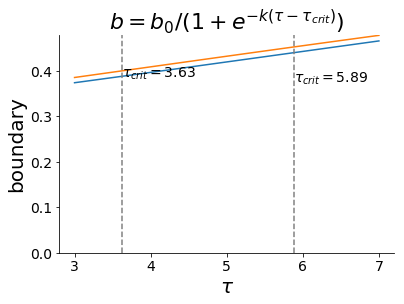

In [60]:
fig, ax = plt.subplots()
plot_b_vs_tau(0.88, 0.105, 5.89, 5, ax)
plot_b_vs_tau(0.8, 0.117, 3.63, 5, ax)

In [61]:
def plot_b_vs_t(b_0, k, tta_crit, tta_0, ax):
    t = np.linspace(0, 2.5)    
    tau = tta_0 - t       
    b = lambda tau: b_0/(1+np.exp(-k*(tau-tta_crit)))
    
    ax.plot(t, b(tau))    
    ax.set_xlabel(r'$t$')
    ax.set_ylabel('boundary (in units of $b_0$)')
    ax.set_ylim((0, max(b(tau))))

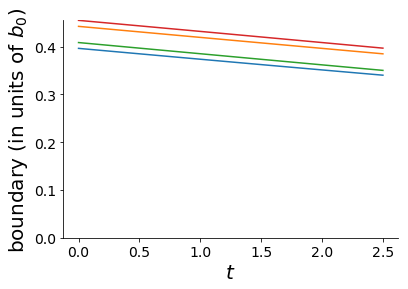

In [68]:
fig, ax = plt.subplots()
plot_b_vs_t(0.88, 0.105, 5.89, 4, ax)
plot_b_vs_t(0.88, 0.105, 5.89, 6, ax)
plot_b_vs_t(0.8, 0.117, 3.63, 4, ax)
plot_b_vs_t(0.8, 0.117, 3.63, 6, ax)

In [18]:
class BoundCollapsingTta(ddm.models.Bound):
    name = 'Bounds collapsing with TTA'
    required_parameters = ['b_0', 'k', 'tta_crit']
    required_conditions = ['tta_condition'] 
    def get_bound(self, t, conditions, **kwargs):
        tau = conditions['tta_condition'] - t
        return self.b_0/(1+np.exp(-self.k*(tau-self.tta_crit)))

param_names = ['alpha', 'tta_crit', 'beta', 'd_crit', 'noise', 'b_0', 'k', 'tta_crit', 'nondectime', 'halfwidth']
tta_crit = ddm.Fittable(minval=3, maxval=6)
    
model_TTA_bounds = ddm.Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time',
                             drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=tta_crit,
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                             noise=ddm.NoiseConstant(noise=1),
                             bound=BoundCollapsingTta(b_0=ddm.Fittable(minval=0.5, maxval=5), 
                                                      k=ddm.Fittable(minval=0.1, maxval=2),
                                                      tta_crit=tta_crit),
                             overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                   halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                             T_dur=T_dur)

# Model fitting to aggregate data

Reading experimental data

In [8]:
exp_data = pd.read_csv('../data/measures.csv', usecols=['subj_id', 'RT', 'is_turn_decision', 'tta_condition', 'd_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

In [ ]:
models = [
          model_tta_distance_dependent_drift, 
          model_nondecision_time_fixed, 
          model_nondecision_time_variable,
          model_collapsing_bounds, 
          model_TTA_bounds
         ]

fit_models = []
for model in models:
    print(model.name)
    directory = '../model_fit_results/tta_and_d/%s/group' % (model.name.lower().replace(' ', '_'))
    fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model)#, lossfunction=LossWLS)
    save_fitting_results(exp_data, fit_model, directory)
    fit_models.append(fit_model)

In [ ]:
for fit_model in fit_models:
    directory = '../model_fit_results/tta_and_d/%s/group' % (model.name.lower().replace(' ', '_'))
    save_fitting_results(exp_data, fit_model, directory)

# Model fitting to individual drivers' data

In [8]:
exp_data = pd.read_csv('measures.csv', usecols=['subj_id', 'RT', 'is_turn_decision', 'tta_condition', 'd_condition'])

In [ ]:
subjects = exp_data.subj_id.unique()

models = [
          model_tta_distance_dependent_drift, 
          model_nondecision_time_fixed, 
          model_nondecision_time_variable,
          model_collapsing_bounds, 
          model_TTA_bounds
         ]

for subject in subjects:
    print('Subject %i' % (subject))
    exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data[exp_data.subj_id==subject], 
                                                  rt_column_name='RT', correct_column_name='is_turn_decision')
    fit_models = []
    for model in models:
        print(model.name)
        directory = 'model_fit_results/tta_and_d/%s/%i' % (model.name.lower().replace(' ', '_'), subject)
        fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model, lossfunction=LossWLS)
        save_fitting_results(exp_data, fit_model, directory)
        fit_models.append(fit_model)